# Modern Portfolio Theory Stock Optimization

### Introduction to MPT
Modern Portfolio Theory (MPT), introduced by Harry Markowitz in 1952, is a mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk. One of the main principles of MPT is that investors are "risk-averse", viewing increased risk as an economic bad. This means that under MPT, increased risk should imply increased reward. This optimization study explores two types of risk and their effects on reward: portfolio beta ($\beta_{portfolio}$) and portfolio volatility ($\sigma_{portfolio}$). 

#### Portfolio Volatility

The portfolio volatility is often denoted as the standard deviation ($\sigma_{portfolio}$) of a group of $N$ assets, and is given by the equation:

$$
\sigma_{portfolio} = \sqrt{\sum_{i=1}^{N}\sum_{j=1}^{N} w_i w_j \sigma_{i} \sigma_{j} \rho_{ij}}
$$

Where:
- $w_i$ and $w_j$ are the weights of assets $i$ and $j$ in the portfolio,
- $\sigma_{i}$ and $\sigma_{j}$ are the standard deviations of returns for assets $i$ and $j$,
- $\rho_{ij}$ is the correlation coefficient between the returns of assets $i$ and $j$.

Portfolio volatility contains both *unsystematic* and *systematic* risk. *Unsystematic* risk refers to company-specific or industry-specific events that affect a certain group of assets. This type of risk is **avoidable** through efficient diversification of uncorrelated assets. On the contrary, *systematic* risk is **unavoidable**, reflecting macro-scale events like changes in inflation rates, taxes, war. These events affect the market as a whole, and can be measured using $\beta$. 

#### Beta

**Beta** is a financial measure of an investment's volatility in relation to the overall market whose $\beta$ = 1. Some asset sectors like "Consumer Staples" are less volatile to market conditions ($\beta$ < 1) whereas other sectors are more volatile than the market like "Consumer Discretionary" ($\beta$ > 1). 

The beta of an individual asset is computed using the following formula:

$$
\beta_{asset} = \frac{\sigma_{\text{asset}} \cdot \rho_{\text{asset,market}}}{\sigma_{\text{market}}}
$$

Where:
- $\sigma_{asset}$ and $\sigma_{market}$ are the standard deviations of returns for the asset and market,
- $\rho_{asset,market}$ is the correlation coefficient between the returns for the asset and market.

The overall portfolio beta is calculated as the weighted average of the individual asset betas, given by the equation:

$$
\text{Portfolio Beta} = \sum_{i=1}^{N} w_i \beta_i
$$

Where:
- $w_i$ is the weight of asset $i$ in the portfolio,
- $\beta_i$ is the beta of asset $i$,
- $N$ is the total number of assets in the portfolio.


Again, the main premise of MPT is increased risk should imply increased reward. Because systematic risks ($\beta$) are unavoidable, there should be extra reward. This extra reward can be visualized with the Security Market Line (SML), a linear relationship between the appropriate unit of extra reward for unit of extra risk. 

$$
E(R_i) = R_f + \beta_i (E(R_m) - R_f)
$$
Where:
- $E(R_i)$ is the expected return of the investment,
- $R_f$ is the risk-free rate (US treasury bills with $\beta$ = 0),
- $\beta_i$ is the beta of the investment,
- $E(R_m)$ is the expected market return.

By applying an investment's $\beta$ to this equation, you can determine its appropriate expected return on the SML. 

#### Expected Return

Reward is measured in terms of **Expected Return** from a given set of assets. 

The expected return of an asset or a portfolio is calculated using the formula:

$$
E(R) = \sum_{i=1}^{n} p_i r_i
$$

Where:
- $E(R)$ is the expected return,
- $p_i$ represents the probability of the $i$-th return,
- $r_i$ is the $i$-th return,
- $n$ is the number of different possible returns.

If an individual asset's expected return is not on the SML, it is mispriced and should correct quickly if markets are efficient. However, for the purpose of this optimization analysis, future expected returns are estimated using random variables (this process is detailed more thoroughly below under the 'Data Preparation' section). This means that assets will commonly be mispriced and the optimization should take advantage of assets that are priced too low (abnormally high expected return for their respective $\beta$). 

## Data Collection and Cleaning

#### Part 1: Data Collection

**Data Sources**

- *"stock_data_SPY.csv"*: Google Finance was used (through Google sheets) to collect weekly closing prices for stocks in the S&P 500 over the **past 5 years**. Only populated 286 stocks with full weekly closing price information. 

- *"stock_sectors.csv"*: Sector source url: "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies". 

In [1]:
# All import statements for project
import gams
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reading in file data
stock_data_spy = pd.read_csv("stock_data_SPY.csv")
stock_sectors = pd.read_csv("stock_sectors.csv")

# transform date
stock_data_spy['Date'] = pd.to_datetime(stock_data_spy['Date'])
stock_data_spy.set_index('Date', inplace=True)

# Calculating the necessary metrics
# Weekly returns
weekly_returns = stock_data_spy.pct_change().dropna()

# Annualized Average Return
years = (stock_data_spy.index[-1] - stock_data_spy.index[0]).days / 365.25
annualized_avg_return = ((stock_data_spy.iloc[-1] / stock_data_spy.iloc[0]) ** (1/years)) - 1

# Annualized Volatility
weekly_volatility = weekly_returns.std() 

# Beta Values
cov_matrix = weekly_returns.cov()
market_variance = weekly_returns['SPY'].var()
beta_values = cov_matrix.loc[:, 'SPY'] / market_variance

# Compiling the data
data_metrics = pd.DataFrame({
    'Annualized Average Return': annualized_avg_return,
    'Weekly Volatility': weekly_volatility,
    'Beta Value': beta_values
})

# Joining with the sectors data
stock_sectors.set_index(stock_sectors.columns[0], inplace=True)
complete_data = data_metrics.join(stock_sectors, how='inner')
complete_data.head()


,Annualized Average Return,Weekly Volatility,Beta Value,Sector
MMM,-0.136077,0.035947,0.865184,Industrials
ABT,0.080846,0.036076,0.755388,Health Care
ACN,0.163710,0.038201,1.085449,Information Technology
ADBE,0.212653,0.048475,1.164405,Information Technology
AMD,0.448503,0.069948,1.498770,Information Technology


### Sector Summaries

In [2]:
sector_stats = complete_data.groupby(stock_sectors.columns[0]).agg({
    'Annualized Average Return': 'mean',
    'Weekly Volatility': 'mean',
    'Beta Value': 'mean'
}).rename(columns={
    'Annualized Average Return': 'Average Return',
    'Weekly Volatility': 'Average Volatility',
    'Beta Value': 'Average Beta'
})

# Counting the total stocks in each sector
sector_stats['Total Stocks'] = complete_data.groupby(stock_sectors.columns[0]).size()

sector_stats

,Average Return,Average Volatility,Average Beta,Total Stocks
Sector,,,,
Communication Services,0.062548,0.042627,0.908172,9
Consumer Discretionary,0.079018,0.054615,1.325326,29
Consumer Staples,0.043583,0.036511,0.626993,28
Energy,0.084867,0.065443,1.156946,18
Financials,0.056629,0.048885,1.202321,47
Health Care,0.080841,0.041126,0.817876,29
Industrials,0.117397,0.043456,1.065299,41
Information Technology,0.165214,0.048441,1.140195,33
Materials,0.063187,0.050561,1.093505,16


### Data Preparation

**GAMS API Preparation**

The expected return of an asset, based on the sector average adjusted by a random variable from a normal distribution, is given by:

$$
E(R_{\text{asset}}) = \mu_{\text{sector}} + Z \cdot \sigma_{\text{sector}}
$$

Where:
- $E(R_{\text{asset}})$ is the expected return of the asset,
- $\mu_{\text{sector}}$ is the average return of the sector,
- $Z$ is a **random variable** drawn from a standard normal distribution (mean = 0, standard deviation = 1),
- $\sigma_{\text{sector}}$ is the standard deviation of weekly returns in the sector.

This expected return methodology simulates a firm's projections after a technical and financial analysis of each asset. 

Note: this project also tracks volatility on a weekly basis instead of annually for maximum granularity. 

In [3]:
returns = sector_stats["Average Return"].to_dict()
volatilities = sector_stats["Average Volatility"].to_dict()
complete_data['Sector Average Return'] = complete_data[' Sector'].map(returns)
complete_data['Sector Average Volatility'] = complete_data[' Sector'].map(volatilities)
np.random.seed(42)

# Calculating new expected return for each asset
final_stocks = complete_data.copy()
final_stocks['expected_return'] = final_stocks['Sector Average Return'] + \
                                  np.random.normal(size=len(final_stocks)) * final_stocks['Sector Average Volatility']

# Selecting and renaming the required columns
final_stocks = final_stocks[['expected_return', 'Weekly Volatility', 'Beta Value', ' Sector']]
final_stocks.rename(columns={
    'Weekly Volatility': 'volatility',
    'Beta Value': 'beta',
    ' Sector': ' Sector'
}, inplace=True)

# Factorizing the Sector column for GAMS API preparation
final_stocks['Sector_factor'] = pd.factorize(final_stocks[' Sector'])[0]

final_stocks.index.name = 'Stock'
final_stocks

,expected_return,volatility,beta,Sector,Sector_factor
Stock,,,,,
MMM,0.138982,0.035947,0.865184,Industrials,0
ABT,0.075154,0.036076,0.755388,Health Care,1
ACN,0.196589,0.038201,1.085449,Information Technology,2
ADBE,0.238991,0.048475,1.164405,Information Technology,2
AMD,0.153872,0.069948,1.498770,Information Technology,2
...,...,...,...,...,...
WYNN,0.115180,0.077425,1.789625,Consumer Discretionary,7
XEL,0.074821,0.035407,0.748127,Utilities,3
XYL,0.063607,0.042426,1.101520,Industrials,0


**Correlation Matrix Preparation** 

In [4]:
weekly_returns_reset = weekly_returns.reset_index()
final_weekly_returns = weekly_returns_reset[final_stocks.index]
corr_matrix = final_weekly_returns.corr()
corr_matrix.head()

,MMM,ABT,ACN,ADBE,AMD,AES,AFL,A,APD,AKAM,...,WDC,WY,WHR,WMB,WEC,WYNN,XEL,XYL,YUM,ZION
MMM,1.000000,0.430483,0.550162,0.412350,0.341070,0.514180,0.566818,0.505864,0.482324,0.381664,...,0.536511,0.550847,0.568439,0.506430,0.389397,0.465813,0.409447,0.660621,0.485623,0.488627
ABT,0.430483,1.000000,0.492621,0.461117,0.323065,0.349297,0.384281,0.589219,0.406689,0.481428,...,0.286549,0.457994,0.471614,0.307854,0.495739,0.289177,0.499166,0.464288,0.520469,0.192200
ACN,0.550162,0.492621,1.000000,0.639912,0.501774,0.571887,0.544641,0.620607,0.505188,0.538812,...,0.458394,0.618165,0.553472,0.412339,0.413559,0.435405,0.440126,0.591189,0.579414,0.456854
ADBE,0.412350,0.461117,0.639912,1.000000,0.542684,0.327634,0.304430,0.559861,0.377009,0.522133,...,0.387812,0.447822,0.473202,0.233099,0.259093,0.319229,0.289783,0.401408,0.362863,0.263275
AMD,0.341070,0.323065,0.501774,0.542684,1.000000,0.274349,0.334777,0.451998,0.367287,0.366011,...,0.446418,0.410199,0.425945,0.283875,0.270680,0.339220,0.273834,0.366960,0.365241,0.263718


## Optimization Using GAMS

This optimization model uses a non-linear programming approach with solver `CONOPT` to find the most optimal combination of assets. 

The `objective` equation aims to maximize the expected return
$$
E(R) = \sum_{i=1}^{n} p_i r_i
$$
However, it is subject to a few **constraints**:
- `total_amt`: investment amount cannot exceed 100% of funds.
$$
\sum_{i=1}^{N} w_i \leq 1
$$
- `vol_cons`: weekly portfolio volatility must not exceed a certain maximum volatility level $\sigma_p$
$$
\sigma_p \geq \sqrt{\sum_{i=1}^{N}\sum_{j=1}^{N} w_i w_j \sigma_{i} \sigma_{j} \rho_{ij}}
$$
- `beta_cons`: the weighted average beta of the portfolio must not exceed a certain maximum weighted average level $\beta_p$
$$
\ \beta_p \geq \sum_{i=1}^{N} w_i \beta_i
$$
- `sector_cons_max` and `sector_cons_min`: Every sector's proportion of final portfolio must remain between levels of $\text{MAX}_S$ and $\text{MIN}_S$ (these were added constraints for extra diversification specifications). 

$$
\sum_{i \in S} w_i \leq \text{MAX}_S
$$
$$
\sum_{i \in S} w_i \geq \text{MIN}_S
$$

Open the GAMS container

In [5]:
%reload_ext gams.magic
m = gams.exchange_container

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


Load in example constraints $\sigma_{max}$ = 2.5%, $\beta_{max}$ = 0.8, $\text{MAX}_S$ = 30%, and $\text{MIN}_S$ = 5%.

In [6]:
%%gams
scalars 
    beta_max /.8/,
    vol_max /.025/,
    max_sector /.3/,
    min_sector /.05/;

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


Add sets, parameters, and variables to the model

In [7]:
ticker = m.addSet('Stock', records=final_stocks.index)
Sector_set = m.addSet('Sector', records=sector_stats.index)

expected_return = m.addParameter('Expected_return', [ticker], records=final_stocks['expected_return'])
standard_dev = m.addParameter('Standard_Dev', [ticker], records=final_stocks['volatility'])
beta_v = m.addParameter('beta_v', [ticker], records=final_stocks['beta'])
sector = m.addParameter('Sector_v', [ticker], records=final_stocks['Sector_factor'])

portfolio = m.addVariable('Portfolio', 'positive', [ticker])
portfolio_return = m.addVariable('Portfolio_return')

CorrelationMatrix = m.addParameter('CorrelationMatrix', [ticker, ticker])

CorrelationMatrix.setRecords(gams.from2dim(corr_matrix))

Add equations and solve the model using non-linear programming

In [8]:
%%gams
alias(i, j, Stock);

Equations objective, total_amt, vol_cons, beta_cons, sector_cons_max(Sector), sector_cons_min(Sector);

objective..
    portfolio_return =e= sum(Stock, expected_return(Stock) * portfolio(Stock)) * sum(Stock, portfolio(Stock));

total_amt..
    1 =g= sum(Stock, portfolio(Stock));

vol_cons..
    vol_max =g= sqrt(sum((i, j), CorrelationMatrix(i, j) * standard_dev(i) * standard_dev(j) * portfolio(i) * portfolio(j))) * sum(Stock, portfolio(Stock));

beta_cons..
    sum(Stock, beta_v(Stock) * portfolio(Stock)) * sum(Stock, portfolio(Stock)) =l= beta_max;

sector_cons_max(Sector)..
    max_sector =g= sum((Stock)$(Sector_v(Stock) = ord(Sector)-1), portfolio(Stock));

sector_cons_min(Sector)..
    min_sector =l= sum((Stock)$(Sector_v(Stock) = ord(Sector)-1), portfolio(Stock));

model portfolio_opt /all/;
solve portfolio_opt using nlp maximizing portfolio_return;


--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),0.188,26,287,NLP,CONOPT,0.25


Python function to extract data from GAMS container back to python for in-depth review of assets in optimized  portfolio.

In [9]:
def get_portfolio_insights(portfolio_records, data, correlation_matrix):
    selected_stocks = portfolio_records[portfolio_records['level'] > 0]

    final_portfolio_df = pd.merge(data, selected_stocks, left_on='Stock', right_on='Stock', how='inner')
    final_portfolio_df = final_portfolio_df[['Stock', 'level', ' Sector', 'expected_return', 'volatility', 'beta']]
    final_portfolio_df.rename(columns={'level': '% Portfolio'}, inplace=True)
    final_portfolio_df['% Portfolio'] = final_portfolio_df['% Portfolio'] * 100  # Adjusting to percentage

    # Calculate weighted averages for return and beta, converting to percentage
    total_percentage = final_portfolio_df['% Portfolio'].sum()
    weighted_avg_return = (final_portfolio_df['expected_return'] * final_portfolio_df['% Portfolio']).sum() * total_percentage / 10000
    weighted_avg_beta = (final_portfolio_df['beta'] * final_portfolio_df['% Portfolio']).sum() / 100
    # Calculate portfolio variance
    # Prepare data for variance calculation
    weights = final_portfolio_df['% Portfolio'].values / 100  # Convert to proportion
    std_devs = final_portfolio_df['volatility'].values
    weighted_std_devs = weights * std_devs

    # Calculate portfolio variance
    portfolio_variance = 0
    for i in range(len(weighted_std_devs)):
        for j in range(len(weighted_std_devs)):
            corr_ij = correlation_matrix.loc[final_portfolio_df.iloc[i]['Stock'], final_portfolio_df.iloc[j]['Stock']]
            portfolio_variance += corr_ij * weighted_std_devs[i] * weighted_std_devs[j]

    # Portfolio standard deviation (volatility)
    portfolio_std_dev = np.sqrt(portfolio_variance) * 100  # Convert to percentage

    # Create summary row
    summary_row = pd.DataFrame(
        [['PORTFOLIO', total_percentage, 'NA', weighted_avg_return, portfolio_std_dev * total_percentage / 10000, weighted_avg_beta * total_percentage / 100]], 
        columns=['Stock', '% Portfolio', ' Sector', 'expected_return', 'volatility', 'beta']
    )

    # Append summary row
    final_portfolio_df = pd.concat([final_portfolio_df, summary_row], ignore_index=True)

    return final_portfolio_df

In [10]:
insights = get_portfolio_insights(portfolio.records, final_stocks, corr_matrix)
insights

,Stock,% Portfolio,Sector,expected_return,volatility,beta
0,ADBE,7.160507,Information Technology,0.238991,0.048475,1.164405
1,AKAM,1.247770,Information Technology,0.191497,0.038352,0.755490
2,BMY,10.744275,Health Care,0.157018,0.032164,0.547158
3,CPB,5.000000,Consumer Staples,0.073615,0.034384,0.241151
4,CCI,5.000000,Real Estate,0.070775,0.039962,0.835119
5,EA,5.000000,Communication Services,0.084426,0.037470,0.567523
6,FSLR,1.229383,Information Technology,0.256583,0.071588,1.069419
7,GE,0.240780,Industrials,0.224438,0.055718,1.153059
8,HD,0.703795,Consumer Discretionary,0.198649,0.042295,1.132514
9,IBM,11.292506,Information Technology,0.240295,0.036335,0.839218


The optimization instance selected 20 stocks from various sectors of the S&P 500 to achieve an expected return of 18.80% annually. Here is a summary of the overall portfolio: 

In [11]:
portfolio_summary = pd.DataFrame(insights.iloc[-1])
portfolio_summary

,20
Stock,PORTFOLIO
% Portfolio,98.497184
Sector,NA
expected_return,0.187978
volatility,0.025
beta,0.79673


Due to the portfolio weekly volatility constraint of 2.5% and sector limitations, the chosen portfolio was only able to use 98.50% of the investment funds.

### Varying Risk Constraints: Effect on Reward

This was just one example of a portfolio. What happens when we vary both the $\beta_{max}$ and $\sigma_{max}$ for this model?

In order to visualize this relationship, a range of $\beta_{max}$ from .42 to .60 and a range of weekly $\sigma_{max}$ from 1.3% to 2.2% was constructed. 

In [12]:
beta_max_range = np.linspace(0.42, .60, 10)  
vol_max_range = np.linspace(0.013, 0.022, 10)

beta_iter = m.addSet('beta_iter', records=beta_max_range)
vol_iter = m.addSet('vol_iter', records=vol_max_range)
results = m.addParameter('results', [beta_iter, vol_iter, 'portfolio_return'])

beta_iters = m.addParameter('beta_iters', [beta_iter], records=beta_max_range)
vol_iters = m.addParameter('vol_iters', [vol_iter], records=vol_max_range)

In [13]:
%%gams
loop(beta_iter,
    beta_max = beta_iters(beta_iter);

    loop(vol_iter,
        vol_max = vol_iters(vol_iter);
        solve portfolio_opt using nlp maximizing portfolio_return;
        results(beta_iter, vol_iter, 'expected_return') = portfolio_return.l;
    );
);

--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).
--- Warning: The GAMS version (44.3.0) differs from the API version (45.4.0).


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),0.0906,26,287,NLP,CONOPT,0.282
1,Normal (1),OptimalLocal (2),0.0973,26,287,NLP,CONOPT,0.188
2,Normal (1),OptimalLocal (2),0.1017,26,287,NLP,CONOPT,0.078
3,Normal (1),OptimalLocal (2),0.1031,26,287,NLP,CONOPT,0.047
4,Normal (1),OptimalLocal (2),0.1031,26,287,NLP,CONOPT,0.063
...,...,...,...,...,...,...,...,...
95,Normal (1),OptimalLocal (2),0.1310,26,287,NLP,CONOPT,0.078
96,Normal (1),OptimalLocal (2),0.1390,26,287,NLP,CONOPT,0.078
97,Normal (1),OptimalLocal (2),0.1452,26,287,NLP,CONOPT,0.062
98,Normal (1),OptimalLocal (2),0.1499,26,287,NLP,CONOPT,0.093


Transfer the results back to python

In [14]:
df = results.records
df.rename(columns={'value': 'expected_return'}, inplace=True)

df['beta_iter'] = pd.to_numeric(df['beta_iter'])
df['vol_iter'] = pd.to_numeric(df['vol_iter'])
df['expected_return'] = pd.to_numeric(df['expected_return'])

df.head()

,beta_iter,vol_iter,uni,expected_return
0,0.42,0.013,expected_return,0.090621
1,0.42,0.014,expected_return,0.097342
2,0.42,0.015,expected_return,0.101709
3,0.42,0.016,expected_return,0.103129
4,0.42,0.017,expected_return,0.103129


100 iterations of this model were conducted to help visualize this relationship. 

### Visualizing relationship in a 3-dimensional space

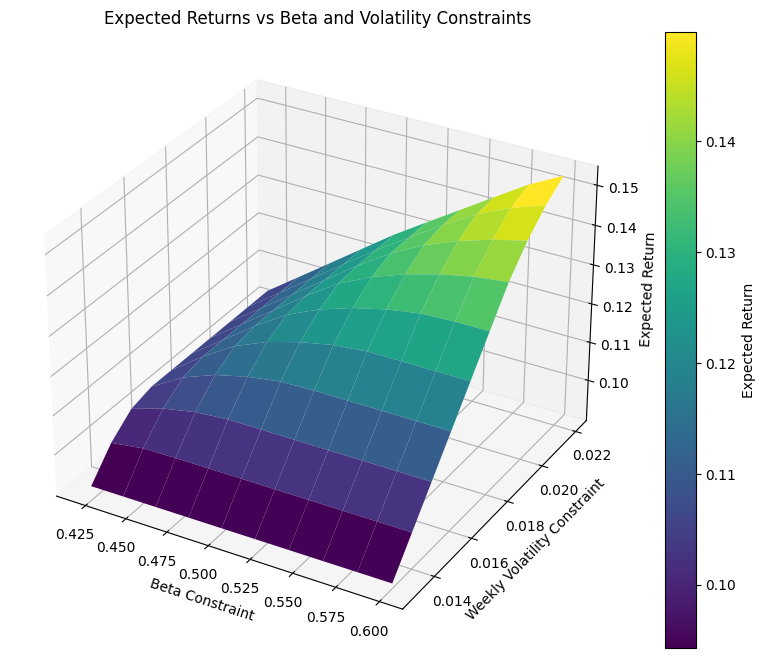

In [15]:
pivot_df = df.pivot_table(index='vol_iter', columns='beta_iter', values='expected_return')

# Create meshgrid for beta and volatility
beta_mesh, vol_mesh = np.meshgrid(pivot_df.columns, pivot_df.index)

# Extracting the expected returns for the meshgrid
expected_returns_mesh = pivot_df.values

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
surface = ax.plot_surface(beta_mesh, vol_mesh, expected_returns_mesh, cmap='viridis')

# Labeling
ax.set_xlabel('Beta Constraint')
ax.set_ylabel('Weekly Volatility Constraint')
ax.set_zlabel('Expected Return')

# Color bar
cbar = plt.colorbar(surface, ax=ax)
cbar.set_label('Expected Return')

plt.title('Expected Returns vs Beta and Volatility Constraints')
plt.show()

### Conclusion

As illustrated by the visual, extra reward (expected returns) is achieved by loosening weekly volatility and beta constraints. 

This aligns with the principles of MPT where higher returns are typically associated with higher levels of risk (portfolio volatility and beta). In our optimization model, relaxing the constraints on volatility and beta allowed for a wider selection of assets with potentially higher returns but also higher market sensitivity and variability in returns.

While risk can be managed under the framework of MPT, it cannot completely eliminated. Therefore, risk management under the MPT framework is crucial for safely maximizing returns. Overall, this project demonstrates that by carefully balancing risk measures (portfolio volatility, beta, and sector proportions) with return, investors can construct a portfolio that aligns with their risk tolerance and return objectives. 

In [16]:
%gams_cleanup --closedown